In [1]:
from timbr import Snapshot
%reload_ext timbr.notebook
%timbr SnapshotSelector

<IPython.core.display.Javascript object>

In [2]:
data = Snapshot("/Users/chelm/.timbr/data/Yolo California with Thumbnails (RapidEye).h5")

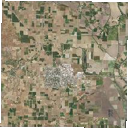

20160501_194712_1056919_RapidEye-1


In [3]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import Image, display
import base64 as b64

@interact(i=widgets.IntSlider(min=0,max=len(data)-1,step=1,value=0))
def f(i):
    display(Image(data=b64.b64decode(data[i][-1]["thumbnail"]["__data__"]), width=250, height=250))
    print data[i][-1]["id"]

In [8]:
"""
Downloads the n-latest visual or analytic geotifs from Planet Labs
Writes images to a directory used to access them from disk in other snippets 
"""

from planet import api
import sys, os
import urllib2, httplib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class NoRedirection(urllib2.HTTPErrorProcessor):
    def http_response(self, request, response):
        return response
    https_response = http_response


def get_image(scene, scene_type='visual', data_dir="./planet_images"):
    opener = urllib2.build_opener(NoRedirection)
    
    img_dir = os.path.join(data_dir, scene_type)
    if not os.path.exists( img_dir ):
        os.makedirs(img_dir)
        
    url = scene['properties']['data']['products'][scene_type]['full']
    
    filename = os.path.join(img_dir, '%s_%s.tif' % (scene['id'], scene_type)) 
    req = urllib2.Request(url, headers={"Authorization": "api-key %s" % api_key})
    response = opener.open(req)
    
    if 'Location' in response.headers:
        redirect_url = response.headers['Location']
        req = urllib2.Request(redirect_url)
        response = opener.open(req)
    
    CHUNK = 16 * 1024
    total = 0
    with open(filename, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                sys.stdout.flush()
                break
                
            total += CHUNK
            sys.stdout.flush()
            sys.stdout.write('\r>> Downloading %s %d' % (filename, total))
            f.write(chunk)
            

# Your Planet Labs API Key
api_key = "65a347d4358348189a800a5eac3bcde7"

def download_latest(data, amount=2, data_dir="./planet_images", scene_type="visual"):
    ids, rows = zip(*data)
    sorted_scenes = sorted(rows, key=lambda k: k['properties']['acquired']) 
    
    for scene in sorted_scenes[-amount:]:
        filename = os.path.join(data_dir, scene_type, scene['id'] + '_' + scene_type + '.tif')
        if not os.path.exists(filename):
            get_image(scene, scene_type=scene_type, data_dir=data_dir)        
        
        sys.stdout.flush()
        print 'Downloaded:', filename

nscenes = 1
download_latest(data, amount=nscenes, scene_type="analytic", data_dir="./yolo")


Downloaded: ./yolo/analytic/20160501_194712_1056919_RapidEye-1_analytic.tif


In [14]:
import numpy
import rasterio
from rasterio.warp import calculate_default_transform, reproject, RESAMPLING

def reproject_tif(src_tif, dst_tif, dst_crs='EPSG:4326'):

    with rasterio.open(src_tif) as src:
        affine, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': affine,
            'affine': affine,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_tif, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.affine,
                    src_crs=src.crs,
                    dst_transform=affine,
                    dst_crs=dst_crs,
                    resampling=RESAMPLING.nearest)

            
src_tif = "./yolo/analytic/20160501_194712_1056919_RapidEye-1_analytic.tif"
dst_tif = "./yolo/analytic/20160501_194712_1056919_RapidEye-1_analytic.wgs84.tif"
reproject_tif(src_tif, dst_tif)
            

-0.572312 0.783244


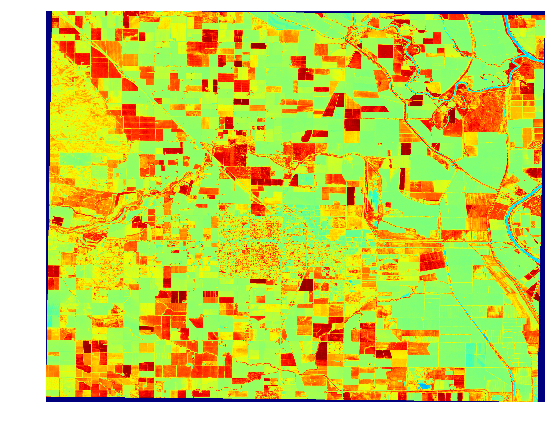

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import rasterio

def ndvi(path):
    with rasterio.drivers():
        with rasterio.open(image_path) as src:
            b, g, r, z, nir, a = src.read().astype(np.float32)
            ndvi = (nir - r)/(nir + r)
            print np.nanmin(ndvi), np.nanmax(ndvi)
            ndvi = (ndvi + 1) * (2**15 - 1)
            ndvi = ndvi.astype(np.uint16)
            
            fig, ax = plt.subplots(1, figsize=(15,7), facecolor='white')
            ax.axis('off')
            img = ax.imshow(ndvi, cmap="jet")

#image_path = 'PATH TO a tif with a NIR channel'
image_path = './yolo/analytic/20160501_194712_1056919_RapidEye-1_analytic.wgs84.tif'
ndvi(image_path)


In [28]:
from ipyleaflet import Map, GeoJSON
import rasterio
import rasterio.features
from affine import Affine
from shapely.geometry import shape
import numpy as np

import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
import os

import json 

def zonal_stats(geojson, tif, bbox=None, NIR_Red=None):
    geodata = []
    with open(geojson) as f:
        data = json.load(f)
        with rasterio.open( tif, 'r') as raster:
            window = None
            if bbox is not None:
                ul = raster.index(*bbox[0:2])
                lr = raster.index(*bbox[2:4])
                window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))
                
            bands = raster.read(window=window).astype(np.float32)
            
            for i, feature in enumerate(data['features']):
                try:
                    geometry = shape(feature['geometry'])
                    ul = raster.index(*geometry.bounds[0:2])
                    lr = raster.index(*geometry.bounds[2:4])

                    t = raster.affine
                    shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

                    stats = []
                    for band in bands:
                        window = band[lr[0]: ul[0]+1, ul[1]:lr[1]+1]
                        try: 
                            mask = rasterio.features.rasterize(
                                [(geometry, 0)],
                                out_shape = window.shape,
                                transform = shifted_affine,
                                fill = 1,
                                all_touched = True,
                                dtype = np.uint8)

                            masked_data = np.ma.array(data=window, mask=mask.astype(bool))

                            stats.append({
                                'min':  window.min(),
                                'mean': window.mean(),
                                'median': np.median(window),
                                'max': window.max()})
                        except:
                            pass

                    # compute indices
                    if NIR_Red is not None: 
                        NIR = bands[NIR_Red[0]][lr[0]: ul[0]+1, ul[1]:lr[1]+1]
                        Red = bands[NIR_Red[1]][lr[0]: ul[0]+1, ul[1]:lr[1]+1]
                        feature['properties']['ndvi'] = np.nanmean((NIR - Red)/(NIR + Red))

                    feature['properties']['stats'] = stats
                    geodata.append(feature)
                except:
                    pass
    return {'features': geodata }

def data_to_colors(data, colormap=mpl.cm.Reds):
    c = [mpl.colors.rgb2hex(d[0:3]) for d in colormap(mpl.colors.Normalize()(data))]
    return c

def show_map(features, vals, lat, lon, zoom, colormap=mpl.cm.rainbow):
    colors = data_to_colors(vals, colormap=colormap)
   
    for feature, color in zip(features, colors):
        feature['properties']['style'] = {'color':color, 'weight': 0, 'fillColor':color, 'fillOpacity':1}

    m = Map(center=[lat, lon], zoom=zoom)
    g = GeoJSON(data={'features': features})
    m.add_layer(g)
    return m


# Path to geojson to compute zonal stats on
# maybe download the json
geojson = './yolo_landuse.json'
if not os.path.exists(geojson):
    import urllib
    urllib.urlretrieve('https://raw.githubusercontent.com/chelm/geodata/master/yolo_landuse.json', geojson)

# path to the tif to use
tif = './yolo/analytic/20160501_194712_1056919_RapidEye-1_analytic.wgs84.tif'

# collect band stats for each polygon for any tif
geodata = zonal_stats(geojson, tif, NIR_Red=(4,2))

# render a map
lon, lat = -121.7894353, 38.70377 #-122.401868, 37.785139
zoom = 11


vals = [f['properties']['ndvi'] for f in geodata['features']]
lmap = show_map(geodata['features'], vals, lat, lon, zoom, colormap=mpl.cm.YlOrRd)

lmap

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


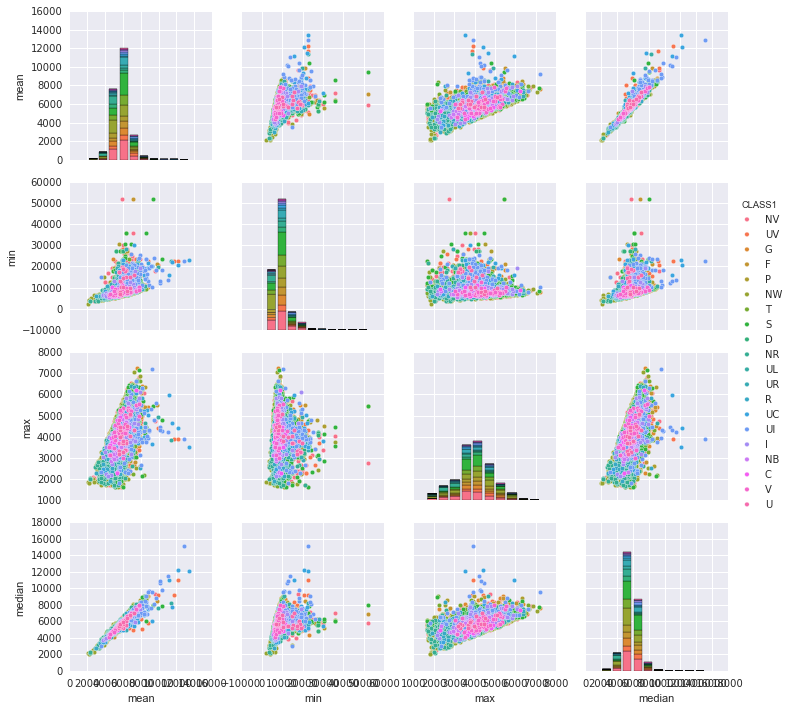

In [43]:
import pandas as pd
import seaborn as sns
sns.set()

def band_pair_plot(features, label, band):
    stats = pd.DataFrame.from_records([
        (f['properties'][label], f['properties']['stats']) for f in features], columns=[label, 'stats'])

    vals = []
    for i in stats.index:
        vals.append((
                stats[label][i], 
                stats['stats'][i][band]['mean'], 
                stats['stats'][i][band]['max'],
                stats['stats'][i][band]['min'],
                stats['stats'][i][band]['median']
            ))

    band_df = pd.DataFrame.from_records(vals, columns=[label, 'mean', 'min', 'max', 'median'])
    sns.pairplot(band_df, hue=label)

label = "CLASS1"
band_pair_plot(geodata['features'], label, 3)

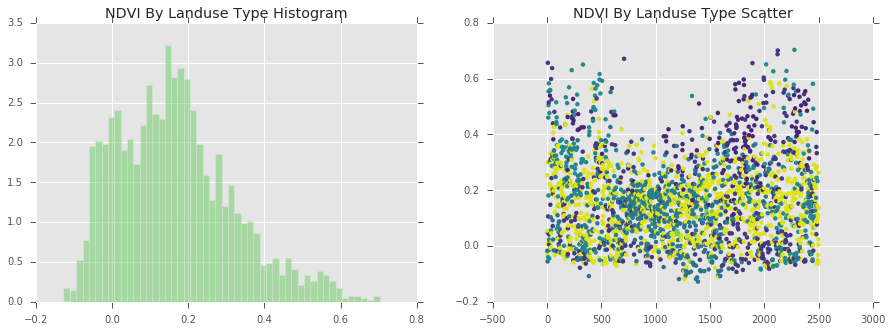

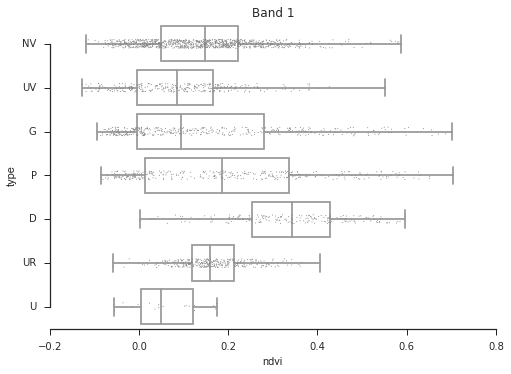

In [58]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.style.use('ggplot')
%matplotlib inline


def n_colors(n, colormap=mpl.cm.viridis):
    data = np.linspace(0.0,1.0,n)
    c = [mpl.colors.rgb2hex(d[0:3]) for d in colormap(data)]
    return c

keys = set([f['properties']['CLASS1'] for f in geodata['features']])
colors = dict(zip(keys, n_colors(len(keys))))

def plot_band( vals, labels, title=None ):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.set_title(title + ' Histogram')
    n, bins, patches = ax1.hist(vals, 50, normed=1, facecolor='g', alpha=0.5)
    ax2.set_title(title + ' Scatter')
    ax2.scatter(range(len(vals)), vals, c=[colors[l] for l in labels], lw=0)
    plt.show()

types = ['G', 'NV', 'UR', 'P', 'U', 'D', 'UV']
vals, labels = zip(*[(f['properties']['ndvi'], f['properties']['CLASS1']) 
                     for f in geodata['features'] if (f['properties']['CLASS1'] in types)])
                   
plot_band( vals, labels, title="NDVI By Landuse Type")


import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

def boxplot( vals, labels):
    means = zip(labels, vals)
    band_means = pd.DataFrame.from_records(means, columns=['type', 'ndvi'])
    ax = sns.boxplot(x="ndvi", y="type", data=band_means,
                 whis=np.inf, color="w")
    sns.stripplot(x="ndvi", y="type", data=band_means,
              jitter=True, size=1, color=".5", linewidth=0)
    ax.set_title('Band '+str(1))
    sns.despine(trim=True)
    
boxplot(vals, labels)


